# Recurrent Neural Networks RNN 
## by Vesna Pop-Dimitrijoska
---

**SimpleRNN, LSTM, and GRU - UNIVARIATE models**

**Datasets:**     
1. `Google_Stock_Price_Train.csv`  
2. `Google_Stock_Price_Test.csv`

**Task:**
1. Forecasting Google Stock Price with a SimpleRNN, LSTM and GRU univariate models for the target column 'Open'.
2. Forecasting Google Stock Price with a SimpleRNN, LSTM and GRU multivariate models for the target "Open", by using "Low", "High", and "Open" as features. (given t, predict t+1)

---
## Loading the libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Read the Dataset

In [2]:
df_train = pd.read_csv('Google_Stock_Price_Train.csv', parse_dates=['Date'], index_col=0).sort_index()
df_test = pd.read_csv('Google_Stock_Price_Test.csv', parse_dates=['Date'], index_col=0).sort_index()

In [3]:
X_train = df_train[['Open']]
X_test = df_test[['Open']]

## Preliminary analysis of a dataset:

Shape of X_train: (1258, 1)
Shape of X_test: (20, 1)


,Open
Date,
2012-01-03,325.25
2012-01-04,331.27
2012-01-05,329.83
2012-01-06,328.34
2012-01-09,322.04


,Open
Date,
2017-01-03,778.81
2017-01-04,788.36
2017-01-05,786.08
2017-01-06,795.26
2017-01-09,806.40


,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


,Open,High,Low,Close
count,20.000000,20.000000,20.000000,20.000000
mean,807.526000,811.926500,801.949500,807.904500
std,15.125428,14.381198,13.278607,13.210088
min,778.810000,789.630000,775.800000,786.140000
25%,802.965000,806.735000,797.427500,802.282500
50%,806.995000,808.640000,801.530000,806.110000
75%,809.560000,817.097500,804.477500,810.760000
max,837.810000,841.950000,827.010000,835.670000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     object 
dtypes: float64(4), object(1)
memory usage: 960.0+ bytes


None

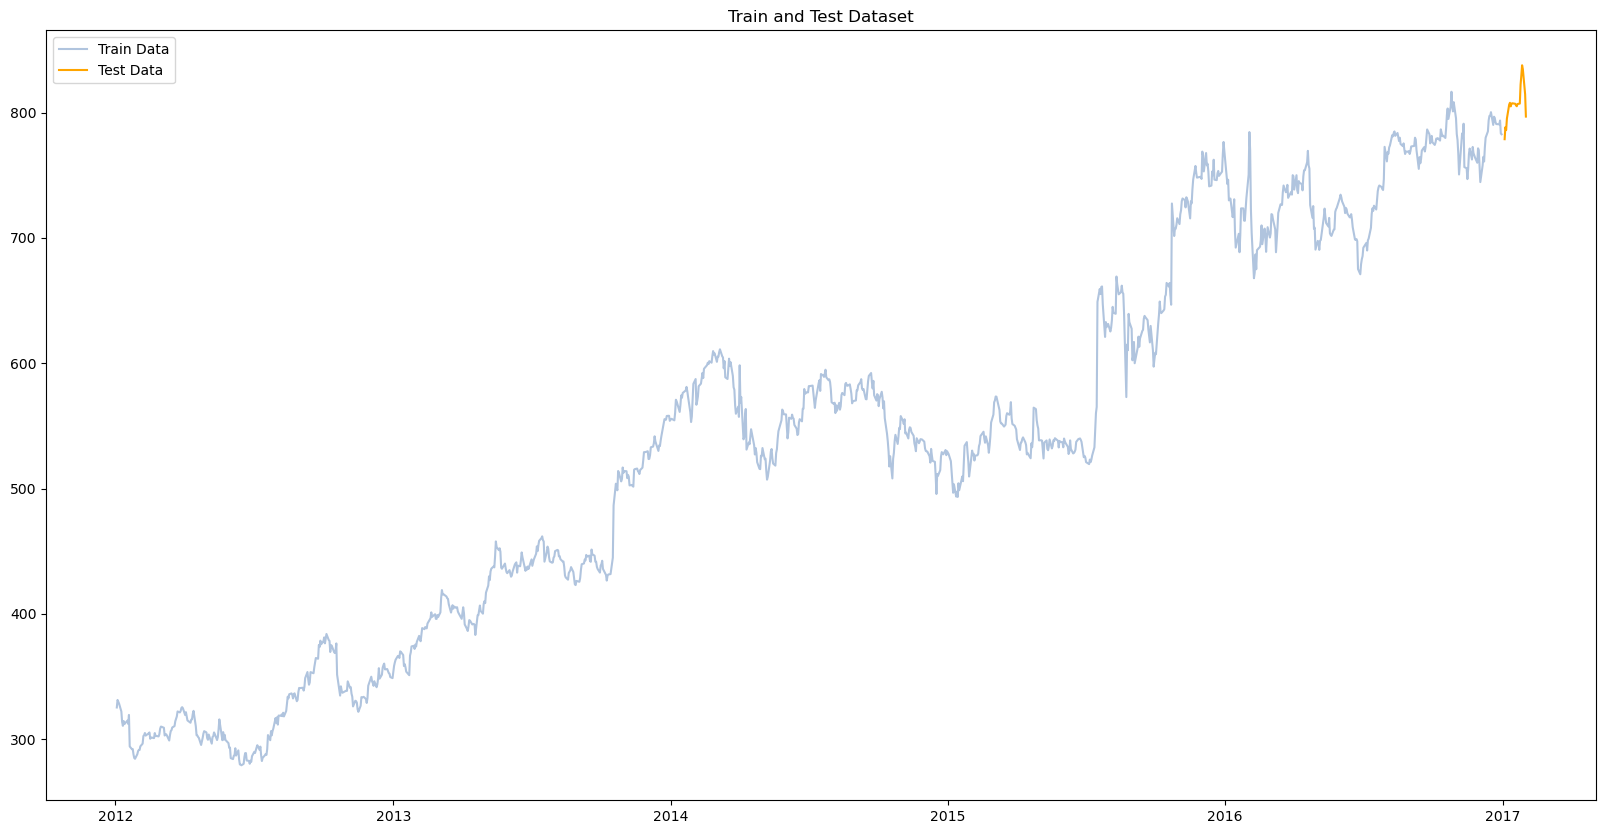

In [4]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

display(X_train.head())
display(X_test.head())

display(df_train.describe())
display(df_test.describe())

display(df_train.info())
display(df_test.info())

plt.figure(figsize=[20,10])
plt.plot(X_train, color='lightsteelblue', label='Train Data')
plt.plot(X_test, color='orange', label='Test Data')
plt.title('Train and Test Dataset')
plt.legend()
plt.show()

In [5]:
X_train = X_train.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)

---
# Preliminary analysis of a dataset:
---
### Shape of a Dataset:     
Shape of the Train dataset is: 1258 rows x 1 columns (without index column - Date column).      
Shape of the Test dataset is: 20 rows x 1 columns (without index column - Date column).

### NaN values:  
There are no NaN values. 

### Data types:  
Data types are correct but they are converted in more efficient data type with smaller precision.  

### Descriptive statistics:
The summary statistics is showing that data are on a similar scale, but should be scaled in order to be easily computed. 

#

---
# Recurrent Neural Networks RNN - Regression model 

# 1) SimpleRNN model
---

## Scaling

In [6]:
train_scaler =  MinMaxScaler()
test_scaler =  MinMaxScaler()

train_scl = train_scaler.fit_transform(X_train)
test_scl = test_scaler.fit_transform(X_test)

## Creating sequences

In [7]:
def create_sequences(seq, n_steps_in):         # many to one
    X, Y = [], []
    for i in range(len(seq) - n_steps_in-1):
        X.append(seq[i:(i+n_steps_in), :])     # t, t+1, t+2...t+(n-1)
        Y.append(seq[i+n_steps_in, :])         # t+n
    return np.array(X), np.array(Y)

In [8]:
features = 1
n_steps_in = 1  # 1, 3, 7

In [9]:
trainX, trainY = create_sequences(train_scl, n_steps_in=n_steps_in)
testX, testY = create_sequences(test_scl, n_steps_in=n_steps_in)

In [10]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(1256, 1, 1) (1256, 1)
(18, 1, 1) (18, 1)


## Model definition

In [11]:
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape= (n_steps_in, features), return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 100)            10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20821 (81.33 KB)
Trainable params: 20821 (81.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Optimization process

In [12]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

## Training the model

In [13]:
es_cbk = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_history = model.fit(
    trainX,
    trainY,
    batch_size=1,
    epochs=100,
    validation_data=(testX, testY),
    callbacks=[es_cbk]
)

Epoch 1/100
1256/1256 [==============================] - 3s 2ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0944 - val_mae: 0.0944
Epoch 2/100
1256/1256 [==============================] - 2s 1ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.1007 - val_mae: 0.1007
Epoch 3/100
1256/1256 [==============================] - 2s 1ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0931 - val_mae: 0.0931
Epoch 4/100
1256/1256 [==============================] - 2s 1ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0913 - val_mae: 0.0913
Epoch 5/100
1256/1256 [==============================] - 2s 1ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0884 - val_mae: 0.0884
Epoch 6/100
1256/1256 [==============================] - 2s 1ms/step - loss: 0.0169 - mae: 0.0169 - val_loss: 0.0988 - val_mae: 0.0988
Epoch 7/100
1256/1256 [==============================] - 2s 1ms/step - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0927 - val_mae: 0.0927
Epoch 8/100
1256/1256 [==============================] 

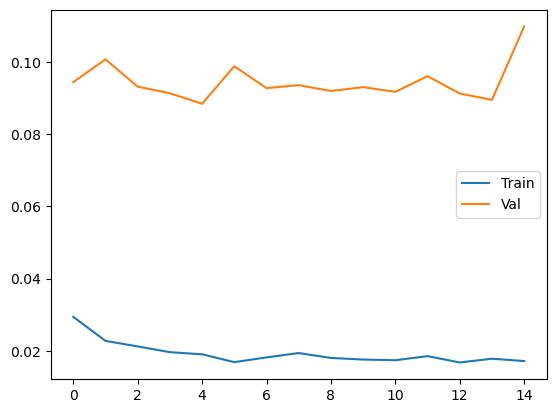

In [14]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['Train', 'Val'])
plt.show()

## Model prediction 

In [15]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

1/1 [==============================] - 0s 16ms/step


## Model evaluation

In [16]:
print('Preformance metrics for SimpleRNN Univariate Model:')
print('--------------------------------------------------')
print("R2 Train:", round(r2_score(trainY, train_predict)*100, 2),'%')
print("R2 Test: ", round(r2_score(testY, test_predict)*100, 2),'%')

Preformance metrics for SimpleRNN Univariate Model:
--------------------------------------------------
R2 Train: 99.47 %
R2 Test:  69.49 %


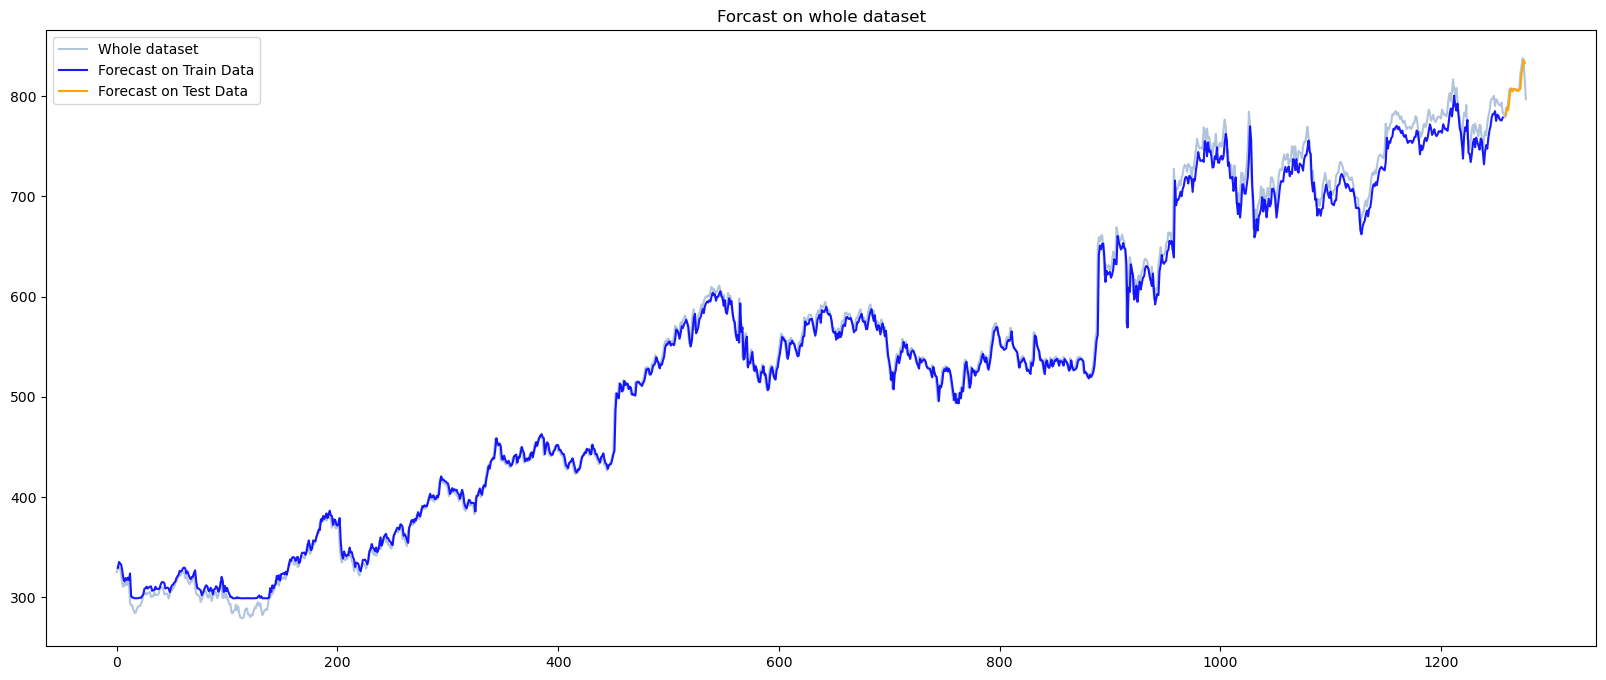

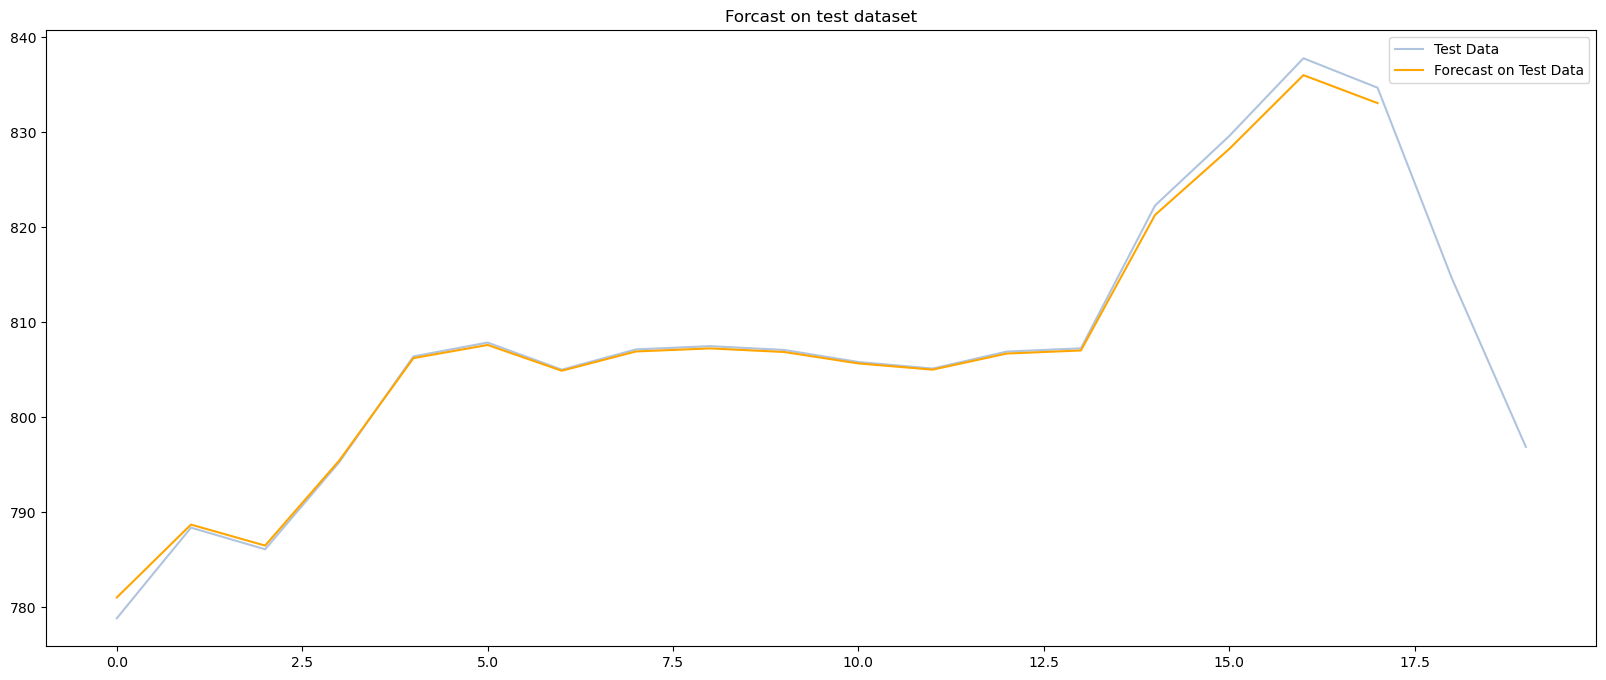

In [17]:
dataset = np.concatenate((X_train, X_test), axis=0)

train_plot = np.empty_like(dataset)
train_plot[:,:] = np.nan
train_plot[n_steps_in:len(train_predict)+n_steps_in, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:,:] = np.nan
test_plot[len(train_predict)+(2*n_steps_in)+1:-1, :] = test_predict

plt.figure(figsize=[20,8])
plt.plot(dataset, color='lightsteelblue', label='Whole dataset')
plt.plot(train_scaler.inverse_transform(train_plot), color='blue', alpha=0.9, label='Forecast on Train Data')
plt.plot(test_scaler.inverse_transform(test_plot), color='orange', label='Forecast on Test Data')
plt.title('Forcast on whole dataset')
plt.legend()
plt.show()

plt.figure(figsize=[20,8])
plt.plot(X_test, color='lightsteelblue', label='Test Data')
plt.plot(test_scaler.inverse_transform(test_predict), color='orange', label='Forecast on Test Data')
plt.title('Forcast on test dataset')
plt.legend()
plt.show()

---
# 2) LSTM model

## Model definition

In [18]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape= (n_steps_in, features), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74071 (289.34 KB)
Trainable params: 74071 (289.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Optimization process

In [19]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

## Training the model

In [20]:
es_cbk = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_history = model.fit(
    trainX,
    trainY,
    batch_size=1,
    epochs=100,
    validation_data=(testX, testY),
    callbacks=[es_cbk]
)

Epoch 1/100
1256/1256 [==============================] - 4s 2ms/step - loss: 0.0453 - mae: 0.0453 - val_loss: 0.0897 - val_mae: 0.0897
Epoch 2/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0919 - val_mae: 0.0919
Epoch 3/100
1256/1256 [==============================] - 3s 2ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0929 - val_mae: 0.0929
Epoch 4/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.1025 - val_mae: 0.1025
Epoch 5/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0915 - val_mae: 0.0915
Epoch 6/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0197 - mae: 0.0197 - val_loss: 0.1033 - val_mae: 0.1033
Epoch 7/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0895 - val_mae: 0.0895
Epoch 8/100
1256/1256 [==============================] 

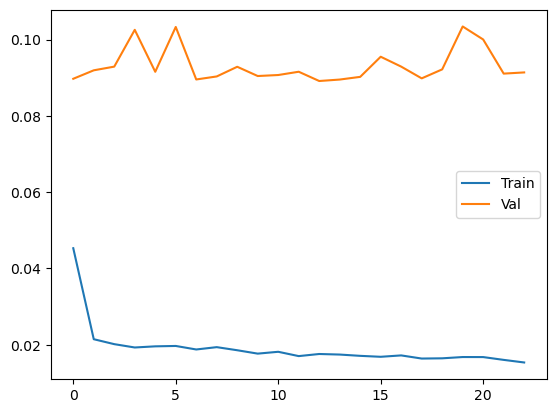

In [21]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['Train', 'Val'])
plt.show()

## Model prediction 

In [22]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

1/1 [==============================] - 0s 17ms/step


## Model evaluation

In [23]:
print('Preformance metrics for LSTM Univariate Model:')
print('----------------------------------------------')
print("R2 Train:", round(r2_score(trainY, train_predict)*100, 2),'%')
print("R2 Test: ", round(r2_score(testY, test_predict)*100, 2),'%')

Preformance metrics for LSTM Univariate Model:
----------------------------------------------
R2 Train: 99.32 %
R2 Test:  69.91 %


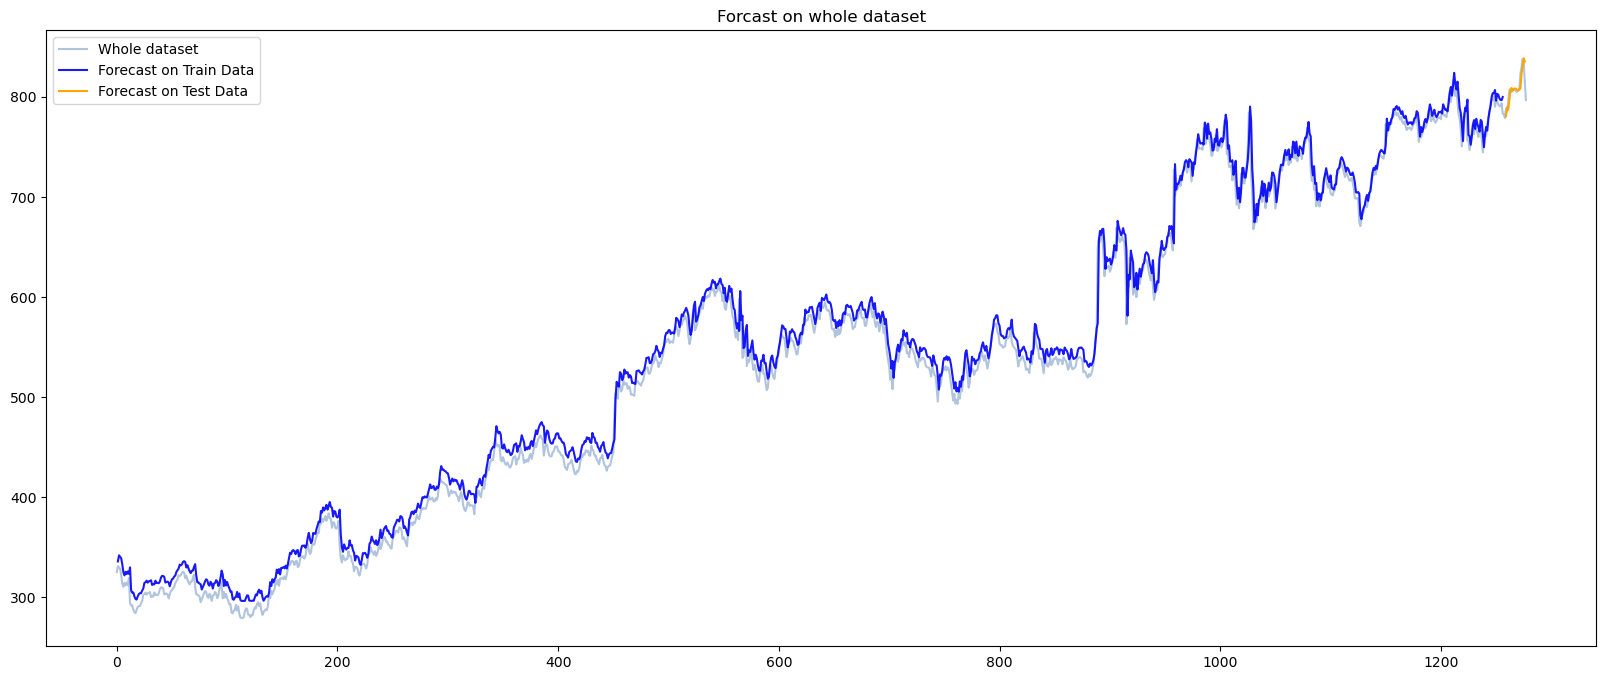

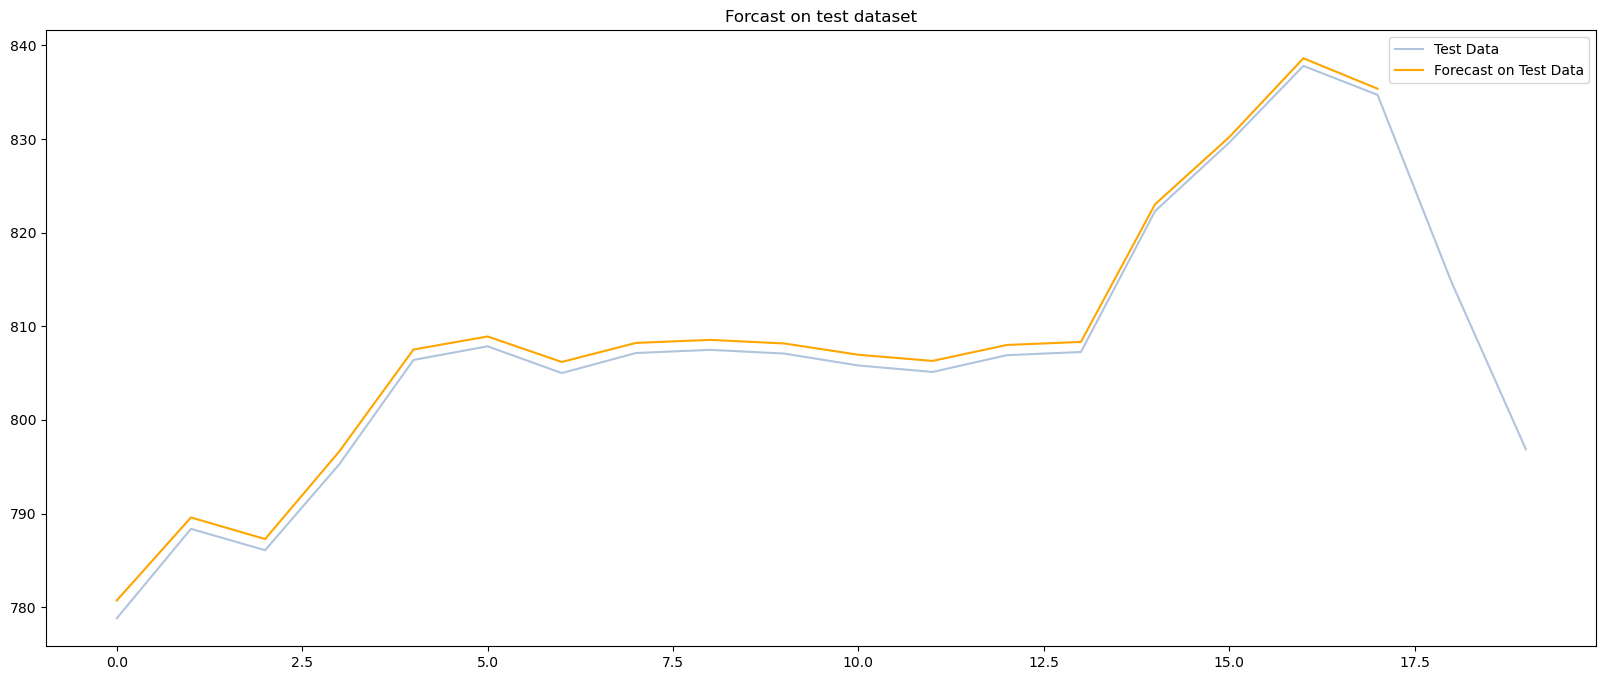

In [24]:
dataset = np.concatenate((X_train, X_test), axis=0)

train_plot = np.empty_like(dataset)
train_plot[:,:] = np.nan
train_plot[n_steps_in:len(train_predict)+n_steps_in, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:,:] = np.nan
test_plot[len(train_predict)+(2*n_steps_in)+1:-1, :] = test_predict

plt.figure(figsize=[20,8])
plt.plot(dataset, color='lightsteelblue', label='Whole dataset')
plt.plot(train_scaler.inverse_transform(train_plot), color='blue', alpha=0.9, label='Forecast on Train Data')
plt.plot(test_scaler.inverse_transform(test_plot), color='orange', label='Forecast on Test Data')
plt.title('Forcast on whole dataset')
plt.legend()
plt.show()

plt.figure(figsize=[20,8])
plt.plot(X_test, color='lightsteelblue', label='Test Data')
plt.plot(test_scaler.inverse_transform(test_predict), color='orange', label='Forecast on Test Data')
plt.title('Forcast on test dataset')
plt.legend()
plt.show()

---
# 3) GRU model

## Model definition

In [25]:
model = Sequential()
model.add(GRU(100, activation='relu', input_shape= (n_steps_in, features), return_sequences=True))
model.add(GRU(50, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 100)            30900     
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 10)                510       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 56771 (221.76 KB)
Trainable params: 56771 (221.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Optimization process

In [26]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

## Training the model

In [27]:
es_cbk = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_history = model.fit(
    trainX,
    trainY,
    batch_size=1,
    epochs=100,
    validation_data=(testX, testY),
    callbacks=[es_cbk]
)

Epoch 1/100
1256/1256 [==============================] - 4s 2ms/step - loss: 0.0385 - mae: 0.0385 - val_loss: 0.0915 - val_mae: 0.0915
Epoch 2/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0900 - val_mae: 0.0900
Epoch 3/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0920 - val_mae: 0.0920
Epoch 4/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0922 - val_mae: 0.0922
Epoch 5/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0941 - val_mae: 0.0941
Epoch 6/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0923 - val_mae: 0.0923
Epoch 7/100
1256/1256 [==============================] - 2s 2ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0901 - val_mae: 0.0901
Epoch 8/100
1256/1256 [==============================] 

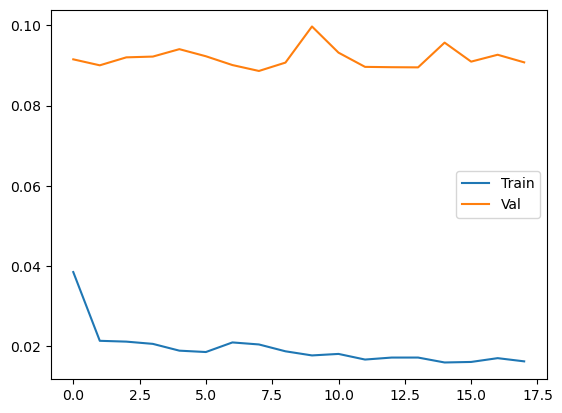

In [28]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['Train', 'Val'])
plt.show()

## Model prediction 

In [29]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

1/1 [==============================] - 0s 19ms/step


## Model evaluation

In [30]:
print('Preformance metrics for GRU Univariate Model:')
print('----------------------------------------------')
print("R2 Train:", round(r2_score(trainY, train_predict)*100, 2),'%')
print("R2 Test: ", round(r2_score(testY, test_predict)*100, 2),'%')

Preformance metrics for GRU Univariate Model:
----------------------------------------------
R2 Train: 99.62 %
R2 Test:  69.25 %


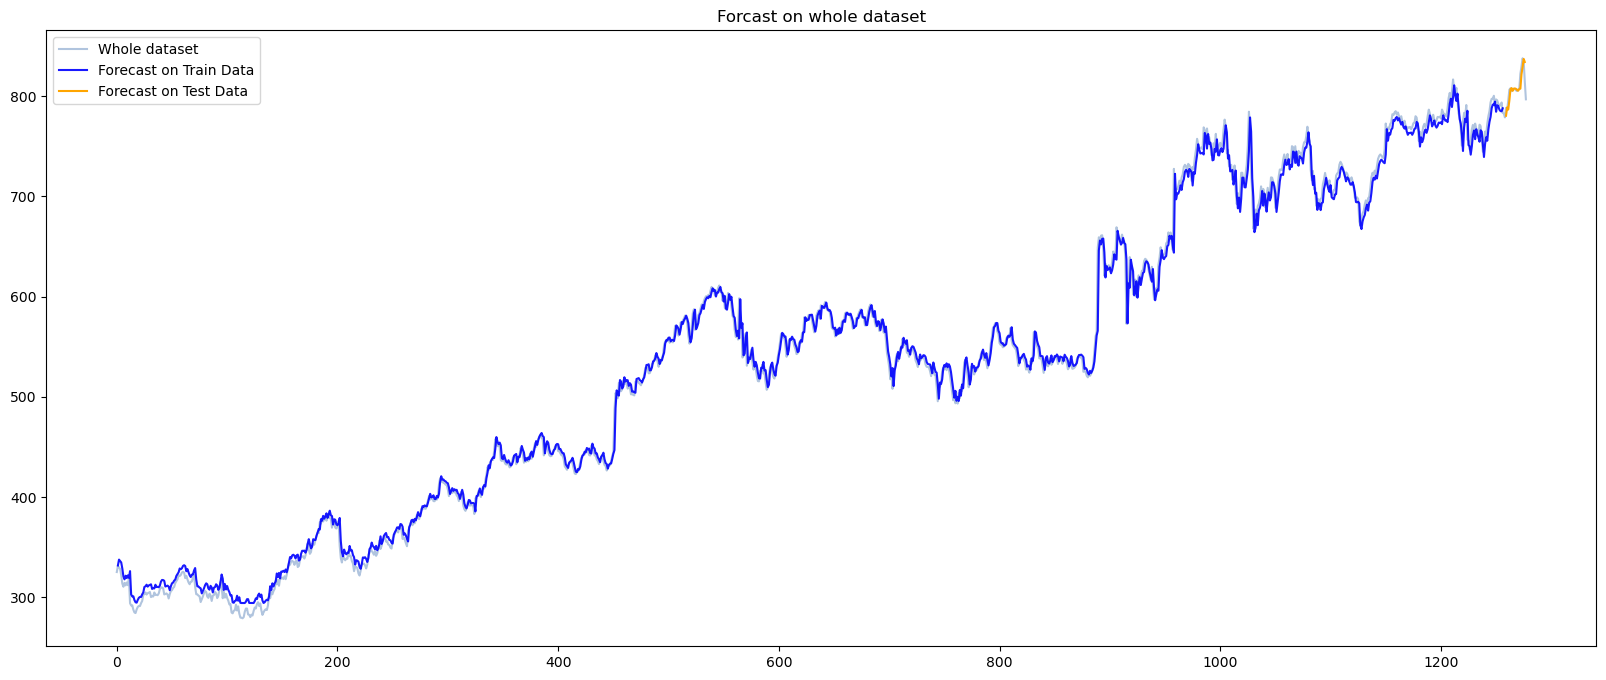

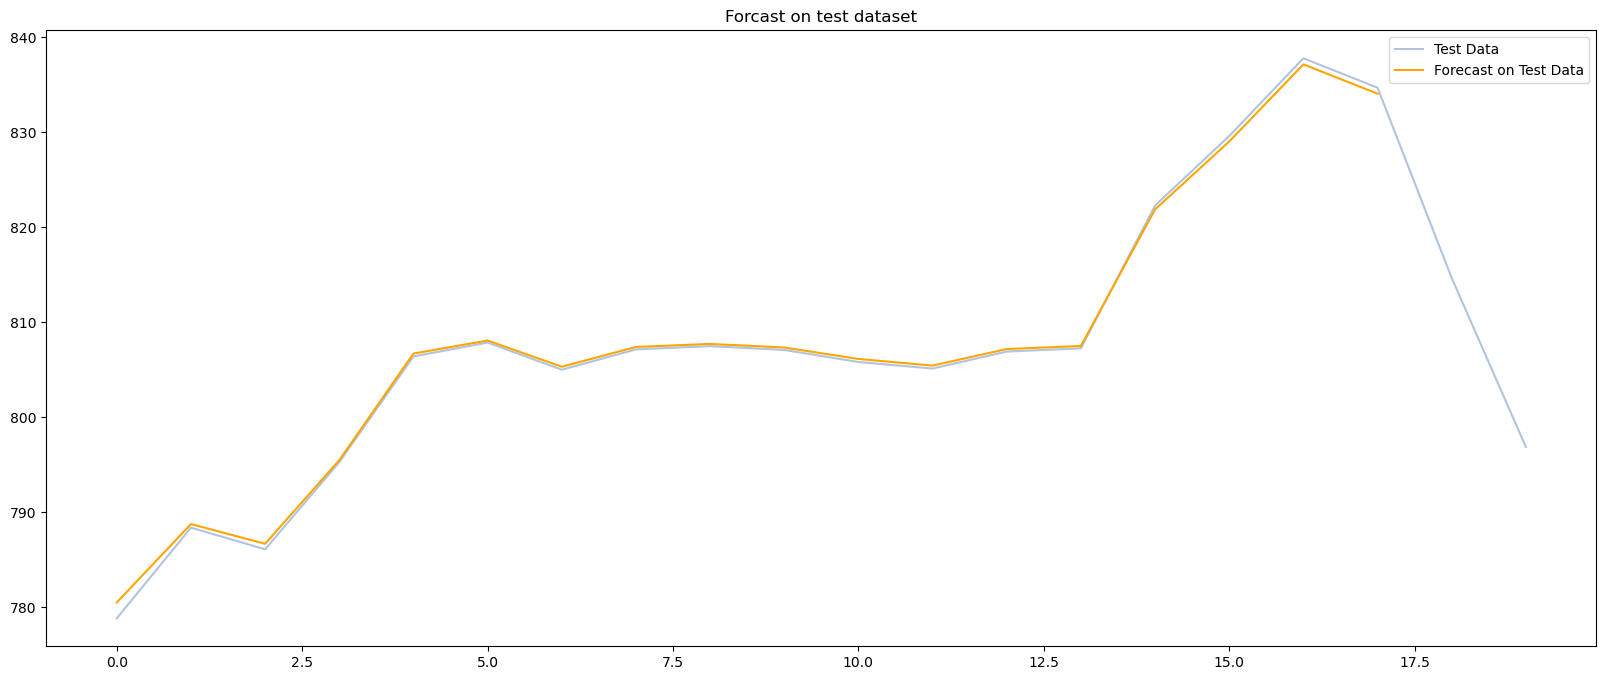

In [31]:
dataset = np.concatenate((X_train, X_test), axis=0)

train_plot = np.empty_like(dataset)
train_plot[:,:] = np.nan
train_plot[n_steps_in:len(train_predict)+n_steps_in, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:,:] = np.nan
test_plot[len(train_predict)+(2*n_steps_in)+1:-1, :] = test_predict

plt.figure(figsize=[20,8])
plt.plot(dataset, color='lightsteelblue', label='Whole dataset')
plt.plot(train_scaler.inverse_transform(train_plot), color='blue', alpha=0.9, label='Forecast on Train Data')
plt.plot(test_scaler.inverse_transform(test_plot), color='orange', label='Forecast on Test Data')
plt.title('Forcast on whole dataset')
plt.legend()
plt.show()

plt.figure(figsize=[20,8])
plt.plot(X_test, color='lightsteelblue', label='Test Data')
plt.plot(test_scaler.inverse_transform(test_predict), color='orange', label='Forecast on Test Data')
plt.title('Forcast on test dataset')
plt.legend()
plt.show()

---
## RESULTS:
####
### 1) n_step = 1
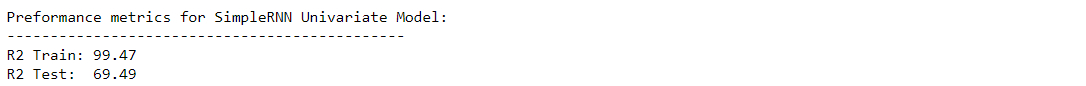
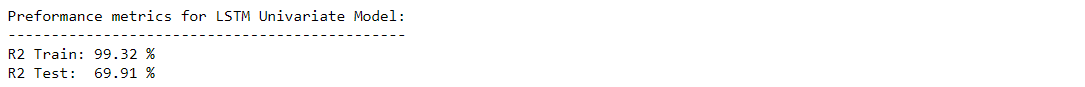
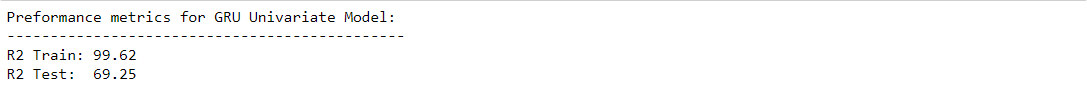

---   
####
### 2) n_step = 3
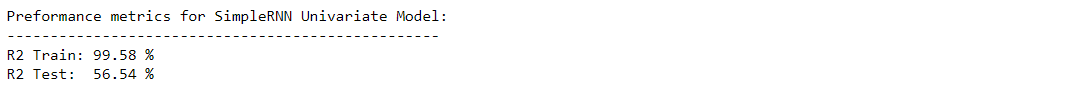
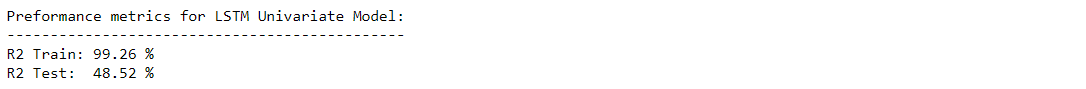
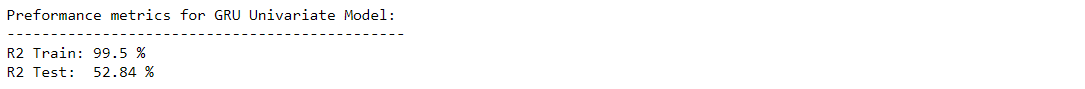

---  
####
### 2) n_step = 7

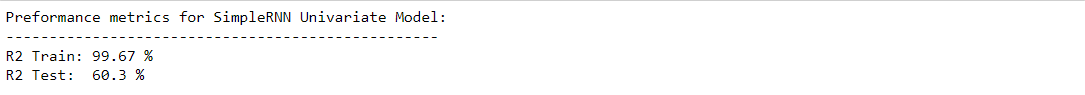
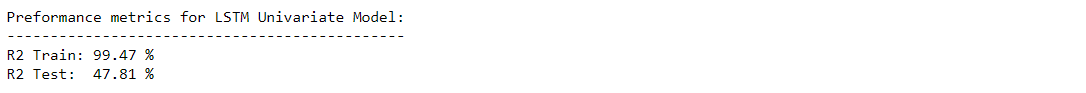
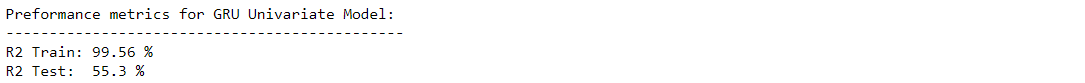

---    
####
## CONCLUSION: 
I experimented with multiple architectures, with different RNN layers, and different time steps. All of them had similar results.
Here I'm using the same architecture but for different RNN models and different time steps: 1, 3, and 7 days.
The best model performance was achieved for the models with a time step of 1 day.

**Note:**      
I'm using batch_size = 1, because it gave me the best model performance. First I used more complex architecture for the model, trying to get the best model performance in order to predict Google Stock Price for real :-). This probably made the model more sensitive to batch size parameter, so the result varied a lot depending on this parameter. Then I changed it into a smaller architecture, so the result became less dependent on batch size.

---